In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
print(device_name)

import pickle
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.applications import Xception

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings('ignore')

/device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dp = "/content/drive/My Drive/Anomaly Detection/Version 2/pickled images and labels/batch1/resized1"
lp = "/content/drive/My Drive/Anomaly Detection/Version 2/pickled images and labels/batch1/labels1"

data, labels = pickle.loads(open(dp, "rb").read()), pickle.loads(open(lp, "rb").read())

In [4]:
le = LabelBinarizer()
labels = le.fit_transform(labels)

In [5]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.15, random_state=42, shuffle=True)

In [6]:
trainAug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    shear_range=0.10,
    horizontal_flip=True,
)

valAug = ImageDataGenerator()

In [7]:
baseModel = Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(240, 320, 3)))

headModel = baseModel.output

headModel = MaxPooling2D(pool_size=(7, 7),)(headModel)

headModel = Flatten(name="flatten")(headModel)

headModel = Dense(512, kernel_regularizer=l2(0.0001), activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)

headModel = Dense(1, activation="sigmoid")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

In [8]:
BS = 128
EPOCHS = 5

print("[INFO] compiling model...")
# opt = SGD(lr=0.0001, momentum=0.7)
opt = Adam(lr=0.0001)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] training head...")

H = model.fit(
    x=trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=valAug.flow(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS
)

[INFO] compiling model...
[INFO] training head...
Epoch 1/5
76/76 [==============================] - 135s 2s/step - loss: 2.9664 - accuracy: 0.6484 - val_loss: 1.1786 - val_accuracy: 0.8149
Epoch 2/5
76/76 [==============================] - 135s 2s/step - loss: 1.4142 - accuracy: 0.7500 - val_loss: 0.4994 - val_accuracy: 0.8726
Epoch 3/5
76/76 [==============================] - 137s 2s/step - loss: 0.8759 - accuracy: 0.7972 - val_loss: 0.3686 - val_accuracy: 0.8798
Epoch 4/5
76/76 [==============================] - 136s 2s/step - loss: 0.6044 - accuracy: 0.8311 - val_loss: 0.4048 - val_accuracy: 0.8750
Epoch 5/5
76/76 [==============================] - 135s 2s/step - loss: 0.4775 - accuracy: 0.8532 - val_loss: 0.3233 - val_accuracy: 0.8870


In [9]:
name = 'model_weights.h5'

model.save_weights(name)

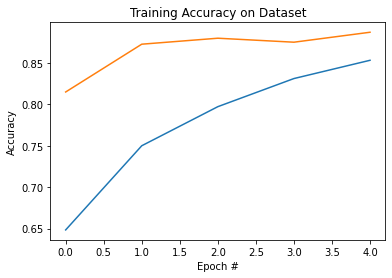

In [10]:
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc");
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc");
plt.title("Training Accuracy on Dataset");
plt.xlabel("Epoch #");
plt.ylabel("Accuracy");

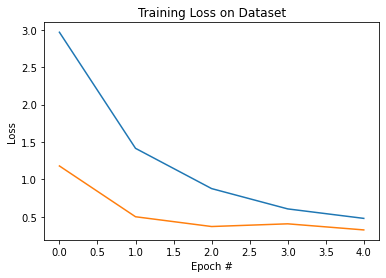

In [11]:
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss");
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss");
plt.title("Training Loss on Dataset");
plt.xlabel("Epoch #");
plt.ylabel("Loss");

In [12]:
ypred = model.predict(testX)

In [13]:
pred = []
yp = ypred.reshape(1,-1)[0]
thresh = 0.5
for val in yp:
  if val>thresh:
    pred.append(1)
  else:
    pred.append(0)

ypred = np.array(pred).reshape(-1,1)

print('Classification Report:\n')
print(classification_report(testY,ypred))
print('Confusion Matrix:\n')
print(confusion_matrix(testY,ypred))

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       864
           1       0.89      0.90      0.90       865

    accuracy                           0.90      1729
   macro avg       0.90      0.90      0.90      1729
weighted avg       0.90      0.90      0.90      1729

Confusion Matrix:

[[771  93]
 [ 86 779]]
